Imports to featurize and load data

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../../")
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data, data_to_features


Data loaded as two dataframes of dances by features, one for basic and one for advanced movement sequences.
Comes from AIST. Downloaded all keypoints for Solo dances (Basic and Advanced = BM, FM)

In [2]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data
dfBasic, dfAdvanced = data_to_features(dataBM, dataFM, sparse=False)  #get features as dataframes


there were index errors on 0 dances


In [3]:
print('There are', len(dfBasic), 'Basic sequences and', len(dfAdvanced), 'Advanced sequences')

There are 1199 Basic sequences and 199 Advanced sequences


In [4]:
#alphabetize dfs by genre (to avoid reordering by classifiers later)
dfAdvanced = dfAdvanced.sort_values(by='Genre')

#make new indexes for Advanced, starting after last index in Basic, for unique index per id
#this is so that Basic and Adv indexes dont overlap.
dfAdvanced.index = range(len(dfBasic.index), len(dfBasic.index)+len(dfAdvanced.index))
dfAdvanced.head() 

,id,Genre,expandedness,expandedness_std
1199,gJB_sFM_cAll_d07_mJB2_ch03,Ballet Jazz,1065.821287,100.792451
1200,gJB_sFM_cAll_d09_mJB5_ch20,Ballet Jazz,943.558702,94.981145
1201,gJB_sFM_cAll_d09_mJB1_ch16,Ballet Jazz,952.453800,100.915748
1202,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz,986.565303,106.354552
1203,gJB_sFM_cAll_d08_mJB0_ch08,Ballet Jazz,980.392101,120.278649


Test set is to be composed only of Advanced dances. This is because each Basic Movement has several, slightly modified versions of the same movement. Thus the problem is more general and more comparable to human genre judging if the test set is Advanced only. Below is a custom splitting function (see data_proc). I used it here for for getting a Test set that is composed entired of Advanced dances. 

Validation/calibration set complicates things, it can include either only Adv, or both.    
Here calib is zeroed it for simplicity and performance.  

   


In [5]:
from DanceProj1.data_proc import traintestval_split
from DanceProj1.data_proc import traintest_split_basic
train, valid, testset = traintestval_split(dfBasic, dfAdvanced, testfrac_adv=.515, testfrac_bas=0, valfrac_adv_nonT=0, valfrac_bas=0)
#train, testset = traintest_split_basic(dfBasic, dfAdvanced)

/home/tbenbaker/MovementClassifier/DanceProj1/notebooks/../../DanceProj1/data_proc.py:199: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testset = pd.concat([testset, test_adv])        #add to testset


In [6]:
print(len(testset), len(valid), len(train))

103 0 1295


The dfs above include ID, for later evaluation. This column should be removed from input.  

traintestval_split also includes genre, which is our target label in this classification task and should accordingly be removed from x and used for y.

In [7]:
test_ids = testset['id']
index_lookup = pd.DataFrame(
               testset.index, columns=['original_index']) #lookup table for original index

X_test = testset.drop(['Genre'], axis=1).drop(['id'], axis=1)
y_test = testset['Genre']

X_valid = valid.drop(['Genre'], axis=1).drop(['id'], axis=1)
y_valid = valid['Genre']

X_train = train.drop(['Genre'], axis=1).drop(['id'], axis=1)
y_train = train['Genre']

In [8]:
#save test ids to csv
#test_ids.to_csv('test_ids.csv', index=False)

In [9]:
from sklearn.preprocessing import StandardScaler
#scale X_test and X_train
scaled_XTest = StandardScaler().fit_transform(X_test)
scaled_Xtrain = StandardScaler().fit_transform(X_train)

X_test = pd.DataFrame(scaled_XTest, index=X_test.index, columns=X_test.columns)
X_train = pd.DataFrame(scaled_Xtrain, index=X_train.index, columns=X_train.columns)
X_test.head()


,expandedness,expandedness_std
1202,-0.242852,1.314329
1215,-0.820341,1.131628
1205,-1.150678,0.614454
1209,-0.122027,1.113450
1201,-0.816588,0.984758


In [10]:
#check for NaNs in X_train
X_train.isnull().values.any()

False

In [11]:
# check the shape 
for item in [X_train, X_test, X_valid, y_valid, y_train, y_test]:
  print(item.shape)

(1295, 2)
(103, 2)
(0, 2)
(0,)
(1295,)
(103,)


In [12]:
labels = list(y_test.unique())
print(labels)

['Ballet Jazz', 'Break', 'House', 'Krump', 'LAhop', 'Lock', 'Midhop', 'Pop', 'Street Jazz', 'Waack']


Let's see how a Perceptron does, no tuning

In [13]:
from sklearn.linear_model import Perceptron
preg = Perceptron(tol=.05, max_iter=2000, alpha=.00001).fit(X_train, y_train)
print('Perceptron is at chance: Score =', preg.score(X_test, y_test))

Perceptron is at chance: Score = 0.17475728155339806


Let's see how a Ridge Classifier does, no tuning 

In [14]:
# #Let's see how a ridge classifier does, no parameter tuning
from sklearn.linear_model import RidgeClassifier
rreg = RidgeClassifier().fit(X_train, y_train)
print('RidgeClassifier is better than chance, but not great. Score =',rreg.score(X_test, y_test))

RidgeClassifier is better than chance, but not great. Score = 0.20388349514563106


Let's see how XGBoost does

In [15]:
#convert to numeric labelsfor xgb
labels = list(y_test.unique())

y_trainxgb = y_train.replace(labels, list(range(len(labels))), regex=True)
y_validxgb = y_valid.replace(labels, list(range(len(labels))), regex=True)
y_testxgb = y_test.replace(labels, list(range(len(labels))), regex=True)
X_trainxgb = X_train.replace(labels, list(range(len(labels))), regex=True)
X_validxgb = X_valid.replace(labels, list(range(len(labels))), regex=True)
X_testxgb = X_test.replace(labels, list(range(len(labels))), regex=True)


print(list(zip(y_test.unique(), y_testxgb.unique())))

[('Ballet Jazz', 0), ('Break', 1), ('House', 2), ('Krump', 3), ('LAhop', 4), ('Lock', 5), ('Midhop', 6), ('Pop', 7), ('Street Jazz', 8), ('Waack', 9)]


In [16]:
#convert to numpy arrays for gridsearch
X_trainxgb = X_train.to_numpy()
X_validxgb = X_valid.to_numpy()
X_testxgb = X_test.to_numpy()
y_trainxgb = y_trainxgb.to_numpy()
y_validxgb = y_validxgb.to_numpy()
y_testxgb = y_testxgb.to_numpy()

from first gridsearch, doesn't look right:   


{'alpha': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.5, 'lambda': 1, 'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 1.0}
should I lambda or alpha reg?

In [17]:
import xgboost as xgb
xgb_mod = xgb.XGBClassifier(objective='multi:softprob', eta =.2, max_depth=8, subsample=.6, random_state=42, n_jobs=16) #try eta = .2 max_depth=10, subsample=.8, random_state=42
xgb_mod.fit(X_train, y_trainxgb)
print('XGBoost is not bad. Score =',xgb_mod.score(X_test, y_testxgb))

#This is not doing as well as in the "inspection" notebook. Haven't been able to figure out why yet.

XGBoost is not bad. Score = 0.13592233009708737


In [18]:
#gridsearch for best parameters
from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate': [0.1, 0.5], 'max_depth': [3, 10], 'gamma': [0, 0.5], 'colsample_bytree': [0.5, 1.0], 'alpha':[0, 0.6],'subsample': [0.5, 1.0], 'min_child_weight': [1, 4]}
xgbmod = xgb.XGBClassifier(objective='multi:softmax', num_class=len(labels))
grid_search = GridSearchCV(xgbmod, parameters, cv=5, scoring = 'f1_macro', n_jobs=16, verbose=1)
grid_search.fit(X_train, y_trainxgb,
                eval_set=[(X_test, y_testxgb)])
                
best_parameters = grid_search.best_params_
print(best_parameters)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[0]	validation_0-mlogloss:2.25047
[1]	validation_0-mlogloss:2.16312
[2]	validation_0-mlogloss:2.12076
[3]	validation_0-mlogloss:2.05102
[4]	validation_0-mlogloss:2.01283
[0]	validation_0-mlogloss:2.25316
[5]	validation_0-mlogloss:1.97438
[6]	validation_0-mlogloss:1.96131
[7]	validation_0-mlogloss:1.91586
[1]	validation_0-mlogloss:2.18736
[8]	validation_0-mlogloss:1.88108
[2]	validation_0-mlogloss:2.15387
[0]	validation_0-mlogloss:2.26314
[9]	validation_0-mlogloss:1.85692
[3]	validation_0-mlogloss:2.08346
[10]	validation_0-mlogloss:1.82435
[4]	validation_0-mlogloss:2.03967
[1]	validation_0-mlogloss:2.19911
[11]	validation_0-mlogloss:1.79689
[2]	validation_0-mlogloss:2.15431
[5]	validation_0-mlogloss:2.00379
[12]	validation_0-mlogloss:1.77100
[0]	validation_0-mlogloss:2.25371
[6]	validation_0-mlogloss:1.98119
[3]	validation_0-mlogloss:2.08769
[13]	validation_0-mlogloss:1.74926
[7]	validation_0-mlogloss:1.93793
[4]	validation_0-mlogloss:2.04344
[14]	validation_0-mlogloss:1.72659
[1]	valid

In [19]:
#best parameters from first gridsearch scoring=accuracy, but "early stopping rounds deprecated"
'alpha': 0, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 1.0

SyntaxError: illegal target for annotation (1807434232.py, line 2)

In [36]:
import xgboost as xgb
xgb_mod = xgb.XGBClassifier(objective='multi:softprob', alpha=0, colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=4, subsample=1.0)
xgb_mod.fit(X_train, y_trainxgb)
print('XGBoost is not bad. Score =',xgb_mod.score(X_test, y_testxgb))

XGBoost is not bad. Score = 0.5436893203883495


In [17]:
y_hatprob = xgb_mod.predict_proba(X_test)   #get probabilities, turn into dataframe, add original index, true label, and id
yprobdf = pd.DataFrame(y_hatprob, columns=labels)   
yprobdf['Original Index'] = index_lookup['original_index']
yprobdf['True_Label'] = y_test.values
yprobdf['id'] = test_ids.values
yprobdf.head()

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.739236,0.110795,0.008194,0.064138,0.008141,0.041353,0.009903,0.002849,0.002849,0.012540,1202,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.014440,0.020785,0.038280,0.049161,0.010648,0.044281,0.037874,0.009355,0.343209,0.431967,1215,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.072963,0.050900,0.086848,0.074143,0.025079,0.327227,0.085513,0.027875,0.153188,0.096264,1205,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
3,0.968920,0.003668,0.002773,0.000299,0.003165,0.000550,0.005248,0.000305,0.010418,0.004655,1209,Ballet Jazz,gJB_sFM_cAll_d07_mJB0_ch01
4,0.304132,0.327664,0.024708,0.018486,0.018001,0.110151,0.098206,0.011295,0.023775,0.063582,1201,Ballet Jazz,gJB_sFM_cAll_d09_mJB1_ch16


In [18]:
#split into dfs by genre
BJazzdf = yprobdf[yprobdf['True_Label']=='Ballet Jazz']
Breakdf = yprobdf[yprobdf['True_Label']=='Break']
Housedf = yprobdf[yprobdf['True_Label']=='House']
Krumpdf = yprobdf[yprobdf['True_Label']=='Krump']
LAhopdf = yprobdf[yprobdf['True_Label']=='LAhop']
Lockdf = yprobdf[yprobdf['True_Label']=='Lock']
Midhopdf = yprobdf[yprobdf['True_Label']=='Midhop']
Popdf = yprobdf[yprobdf['True_Label']=='Pop']
SJazzdf = yprobdf[yprobdf['True_Label']=='Street Jazz']
Waackdf = yprobdf[yprobdf['True_Label']=='Waack']

Genredfs = [BJazzdf, Breakdf, Housedf, Krumpdf, LAhopdf, Lockdf, Midhopdf, Popdf, SJazzdf, Waackdf]


([<matplotlib.axis.YTick at 0x7fe74c39c2b0>,
 [Text(0, 0, 'Ballet Jazz'),
  Text(0, 1, 'Break'),
  Text(0, 2, 'House'),
  Text(0, 3, 'Krump'),
  Text(0, 4, 'LAhop'),
  Text(0, 5, 'Lock'),
  Text(0, 6, 'Midhop'),
  Text(0, 7, 'Pop'),
  Text(0, 8, 'Street Jazz'),
  Text(0, 9, 'Waack')])

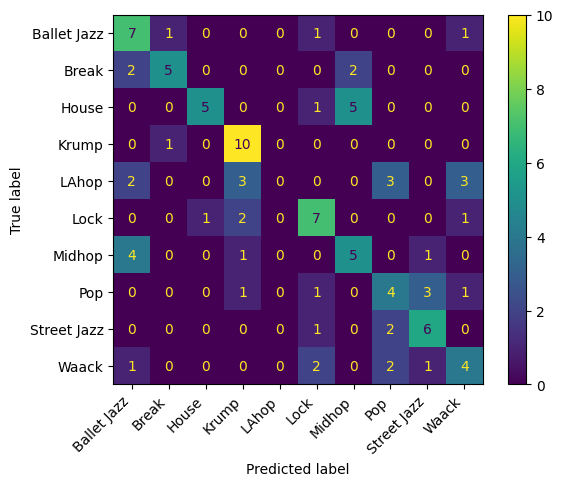

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_mod, X_testxgb, y_testxgb)
#change xticks and yticks to labels
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels, rotation=45, ha='right')
plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels)


In [ ]:
#what stands out about lock, such that it prefers to predict it over other genres?


<AxesSubplot: title={'center': 'Ballet Jazz'}, ylabel='Probability'>

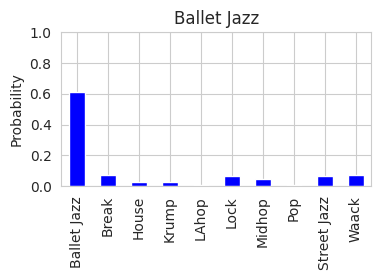

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
#remove original index, true label, and id for each house pieces, plt the mean probabiltiies
sns.set_style('whitegrid')
dfBJ = BJazzdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfBJ.mean().plot(kind='bar', title='Ballet Jazz', color='blue', figsize=(4,2), ylim=(0,1), ylabel='Probability')
#plt.savefig('../plots/proba_plots/BJazzprob.png')


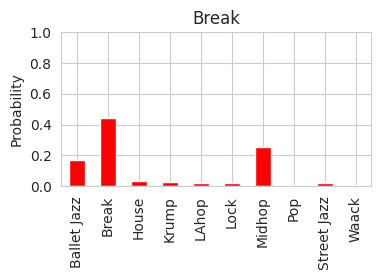

In [23]:
dfBR = Breakdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfBR.mean().plot(kind='bar', title='Break', color='red', figsize=(4,2), ylim=(0,1), ylabel='Probability')
#plt.savefig('../plots/proba_plots/Breakprob.png')
plt.show()

<AxesSubplot: title={'center': 'House'}, ylabel='Probability'>

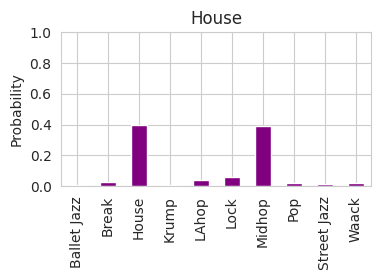

In [24]:
dfHO = Housedf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfHO.mean().plot(kind='bar', title='House', color='purple', figsize=(4,2), ylim=(0,1), ylabel='Probability')
#plt.savefig('../plots/proba_plots/Houseprob.png')

<AxesSubplot: title={'center': 'Krump'}, ylabel='Probability'>

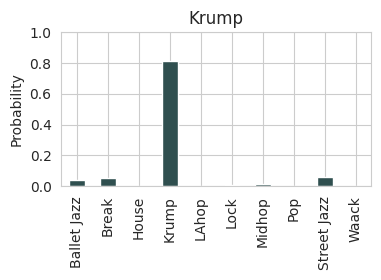

In [25]:
dfKR = Krumpdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfKR.mean().plot(kind='bar', title='Krump', color='darkslategray', figsize=(4,2), ylim=(0,1), ylabel='Probability')
#plt.savefig('../plots/proba_plots/Krumpprob.png')

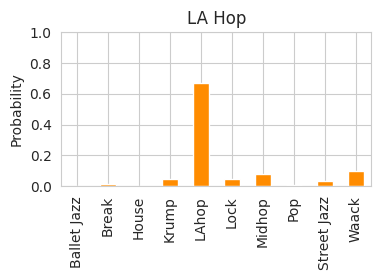

In [26]:
dfLA = LAhopdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfLA.mean().plot(kind='bar', title='LA Hop', color='darkorange', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/LAprob.png')

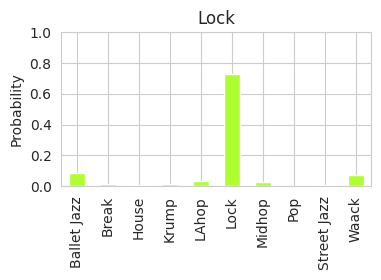

In [30]:
dfLO = Lockdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfLO.mean().plot(kind='bar', title='Lock', color='greenyellow', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Lockprob.png')

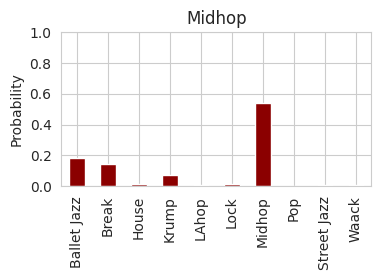

In [31]:
dfMI = Midhopdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfMI.mean().plot(kind='bar', title='Midhop', color='darkred', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Midprob.png')

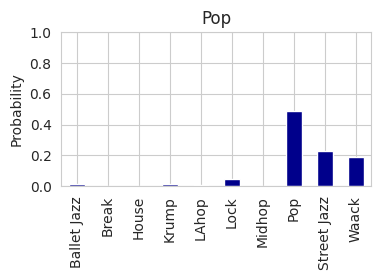

In [32]:
dfPO = Popdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfPO.mean().plot(kind='bar', title='Pop', color='darkblue', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Popprob.png')

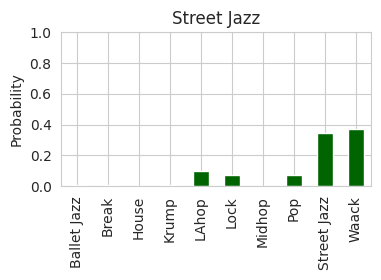

In [33]:
dfSJ = SJazzdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfSJ.mean().plot(kind='bar', title='Street Jazz', color='darkgreen', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/SJprob.png')

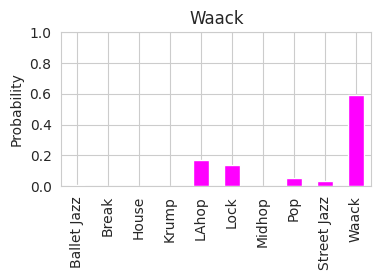

In [34]:
dfWA = Waackdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfWA.mean().plot(kind='bar', title='Waack', color='magenta', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Waackprob.png')

In [15]:
rreg = RidgeClassifier().fit(X_train, y_train)
print('RidgeClassifier is better than chance, but not great. Score =',rreg.score(X_test, y_test))

RidgeClassifier is better than chance, but not great. Score = 0.34375


In [21]:
from sklearn.calibration import CalibratedClassifierCV
calibrxgb = CalibratedClassifierCV(xgb_mod, cv='prefit', method='sigmoid')

calibrxgb.fit(X_validxgb, y_validxgb)
y_hatpc = calibrxgb.predict_proba(X_test)
print(y_hatpc.shape)
print('Calibrated XGBoost is...worse? Score =',calibrxgb.score(X_test, y_testxgb))

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

##### Now for auto-sklearn. The two main parameters for auto-sklearn are:   
- time_left_for_this_task, optional (default=3600): Time limit in seconds for the search of appropriate models. By increasing this value, auto-sklearn has a higher chance of finding better models.  
- per_run_time_limit, optional (default=1/10 of time_left_for_this_task): Time limit for a single call to the machine learning model. Model fitting will be terminated if the machine learning algorithm runs over the time limit. Set this value high enough so that typical machine learning algorithms can be fit on the training data.


In [17]:
import autosklearn.classification
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import sklearn.datasets
import sklearn.metrics

In [20]:
# Instantiate an automl classifier model object with time limits
automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=400,
        per_run_time_limit=80,
        include={'classifier': ['gradient_boosting']}
)

# Fit the classifier to training data
automl.fit(X_train, y_train)
print('Score =', automl.score(X_test, y_test))

OpenBLAS blas_thread_init: pthread_create failed for thread 17 of 24: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 63847 current, 63847 max
OpenBLAS blas_thread_init: pthread_create failed for thread 18 of 24: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 63847 current, 63847 max
OpenBLAS blas_thread_init: pthread_create failed for thread 19 of 24: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 63847 current, 63847 max
OpenBLAS blas_thread_init: pthread_create failed for thread 20 of 24: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 63847 current, 63847 max
OpenBLAS blas_thread_init: pthread_create failed for thread 21 of 24: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 63847 current, 63847 max
OpenBLAS blas_thread_init: pthread_create failed for thread 22 of 24: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 63847 current, 63

[ERROR] [2022-12-29 09:22:07,125:Client-AutoML(1):299b88ab-8784-11ed-81aa-00155d5878b2] (' Dummy prediction failed with run state StatusType.CRASHED and additional output: {\'error\': \'Result queue is empty\', \'exit_status\': "<class \'pynisher.limit_function_call.AnythingException\'>", \'subprocess_stdout\': \'\', \'subprocess_stderr\': \'Process pynisher function call:\\nTraceback (most recent call last):\\n  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap\\n    self.run()\\n  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run\\n    self._target(*self._args, **self._kwargs)\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/pynisher/limit_function_call.py", line 133, in subprocess_func\\n    return_value = ((func(*args, **kwargs), 0))\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/autosklearn/evaluation/__init__.py", line 55, in fit_predict_try_except_decorator\\n    return ta(queue=queue, **kwargs)\\n  File 

ValueError: (' Dummy prediction failed with run state StatusType.CRASHED and additional output: {\'error\': \'Result queue is empty\', \'exit_status\': "<class \'pynisher.limit_function_call.AnythingException\'>", \'subprocess_stdout\': \'\', \'subprocess_stderr\': \'Process pynisher function call:\\nTraceback (most recent call last):\\n  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap\\n    self.run()\\n  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run\\n    self._target(*self._args, **self._kwargs)\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/pynisher/limit_function_call.py", line 133, in subprocess_func\\n    return_value = ((func(*args, **kwargs), 0))\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/autosklearn/evaluation/__init__.py", line 55, in fit_predict_try_except_decorator\\n    return ta(queue=queue, **kwargs)\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/autosklearn/evaluation/train_evaluator.py", line 1191, in eval_holdout\\n    evaluator = TrainEvaluator(\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/autosklearn/evaluation/train_evaluator.py", line 206, in __init__\\n    super().__init__(\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/autosklearn/evaluation/abstract_evaluator.py", line 215, in __init__\\n    threadpool_limits(limits=1)\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/threadpoolctl.py", line 373, in __init__\\n    super().__init__(ThreadpoolController(), limits=limits, user_api=user_api)\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/threadpoolctl.py", line 166, in __init__\\n    self._set_threadpool_limits()\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/threadpoolctl.py", line 299, in _set_threadpool_limits\\n    lib_controller.set_num_threads(num_threads)\\n  File "/home/tbenbaker/.local/lib/python3.8/site-packages/threadpoolctl.py", line 865, in set_num_threads\\n    return set_func(num_threads)\\nKeyboardInterrupt\\n\', \'exitcode\': 1, \'configuration_origin\': \'DUMMY\'}.',)

In [ ]:
# Model search statistics
print(automl.sprint_statistics())

In [ ]:
# Model Description
print(automl.show_models())

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
calibr = CalibratedClassifierCV(automl, cv='prefit', method='isotonic')

calibr.fit(X_valid, y_valid)
y_hatp = calibr.predict_proba(X_test)